# Package

In [276]:
#Pytorch
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset

#For data preprocessing
import numpy as np
import pandas as pd
import itertools
from sklearn.preprocessing import StandardScaler
import os
import random
import csv
import gc

#For plotting
import matplotlib.pyplot as plt

#For reproducibility
myseed = 42069  # set a random seed for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Data Preprocessing

In [485]:
class EPADataSet(Dataset):
    """Dataset for loading and preprocessing the EPA Weather data
    """
    def __init__(self, path, mode = "train", num_lag = 7, train_valid_ratio = 0.75, scaler = None, train_index = None, kept_columns = None):
        self.mode = mode
        data = self.load_data(path)
        if mode in ["train", "valid"]:
            self.preprocess_train_valid(data, num_lag, scaler, train_valid_ratio, train_index, kept_columns)
        else:
            self.preprocess_test(data, num_lag, scaler, kept_columns)  
        
        print(f"Finish reading {self.mode} dataset ({len(self.data)} samples, {self.dim} features)")
        if mode in ["train", "valid"]:
            print("Check target size... The target size is {len(self.target)}")
        #print(self.data)

    def preprocess_train_valid(self, data, num_lag, scaler, train_valid_ratio, train_index, kept_columns):
        #split dataset to X and y
        X = data.loc[:, data.columns != "PM2.5"]
        y = data.loc[:, data.columns == "PM2.5"]

        #get lag variable
        X = self.get_lag_variable(X, num_lag)
        X.dropna(inplace = True)
        if self.mode == "train":
            #record kept columns
            corr_features = abs(X.corrwith(y['PM2.5'])).sort_values(ascending=False)
            self.kept_columns = (corr_features[corr_features > 0.5]).index
            #print(self.kept_columns)
            X = X[self.kept_columns]
            #standardize
            self.scaler = StandardScaler().fit(X)
            X = self.scaler.transform(X)
        
        else: #valid mode
            X = X[kept_columns]
            X = scaler.transform(X)
        #train valid split
        random.seed(5)
        data_len = len(X)
        if self.mode == "train":
            train_len = round(train_valid_ratio * data_len)
            index = random.sample(range(data_len), train_len)
            self.train_index = index
        else: 
            index = [i for i in range(data_len) if i not in train_index]
            #print(index)
        X_split = X[index]
        self.dim = X_split.shape[1]
        self.data = torch.FloatTensor(X_split)
        self.target = torch.FloatTensor(np.array(y)[index])

    def preprocess_test(self, data, num_lag, scaler, kept_columns):
        data = self.get_lag_variable(data, num_lag)
        data = data[kept_columns]
        data = scaler.transform(data)
        self.dim = data.shape[1]
        self.data = torch.FloatTensor(data)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode in ["train", "valid"]:
            return self.data[index], self.target[index]
        else:
            return self.data[index]

    def load_data(self, path):
        data = pd.read_csv(path)
        return data

    def get_lag_variable(self, data: pd.DataFrame, num_lag: int):
        #start from 0
        data_ = data.copy()
        for idx in range(num_lag):
            #start from 1
            time = idx + 1
            lag_data = data.shift(time)
            lag_data.columns = [col + "_" + str(-time) for col in data.columns]
            data_ = pd.concat([data_, lag_data], axis = 1)
        #fill testing set nan with "mean"
        if self.mode == "test":
            data_.fillna(data_.mean(), inplace = True)
        return data_

In [382]:
def prep_dataloader(path, mode, batch_size, num_lag, train_valid_ratio, scaler = None, train_index = None, kept_columns = None, n_jobs = 0):
    """Generates a dataset, then is put into a dataloader. 
    """
    dataset = EPADataSet(path, mode, num_lag, train_valid_ratio, scaler, train_index, kept_columns)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle = (mode == "train"), drop_last=False,
        num_workers = n_jobs, pin_memory=True)
    if mode == "train":
        scaler = dataset.scaler
        train_index = dataset.train_index
        kept_columns = dataset.kept_columns
    return dataloader, scaler, train_index, kept_columns

In [374]:
preprocess_params = {
    "num_lag": 7,
    "train_valid_ratio": 0.75,
    "batch_size": 512
}

In [358]:
data_path = "./data/"
train_path = os.path.join(data_path, "training_data.csv")
test_path = os.path.join(data_path, "testing_data.csv")

In [486]:
train_set, train_scaler, train_index, kept_columns = prep_dataloader(
    train_path, "train", preprocess_params["batch_size"], preprocess_params["num_lag"],
    preprocess_params["train_valid_ratio"])
valid_set, _, _, _ = prep_dataloader(
    train_path, "valid", preprocess_params["batch_size"], preprocess_params["num_lag"],
    preprocess_params["train_valid_ratio"], train_scaler, train_index, kept_columns)
test_set, _, _, _ = prep_dataloader(
    test_path, "test", preprocess_params["batch_size"], preprocess_params["num_lag"],
    preprocess_params["train_valid_ratio"], train_scaler, train_index, kept_columns)

Finish reading train dataset (6583 samples, 20 features)
Check target size... The target size is {len(self.target)}
tensor([[-1.3761, -1.1737, -1.1063,  ..., -1.2061, -1.2064, -0.7330],
        [-1.1400, -1.0051, -0.8703,  ..., -0.6147, -0.6146, -0.6147],
        [-0.5328, -0.2969,  0.1076,  ...,  1.1594,  1.1606,  1.1593],
        ...,
        [ 0.6140,  1.1533,  1.3553,  ..., -0.0233, -0.6146, -0.6147],
        [-0.5463, -0.5566, -0.6308,  ..., -1.2061, -0.7330, -0.6147],
        [-0.0269,  0.0067, -0.2633,  ..., -0.6147, -0.0229, -1.2061]])
Finish reading valid dataset (2194 samples, 20 features)
Check target size... The target size is {len(self.target)}
tensor([[ 2.8741,  2.6710,  2.0296,  ...,  1.7508,  1.7524,  1.7506],
        [ 2.2332,  2.8396,  3.1761,  ...,  1.7508,  0.5689,  2.3419],
        [ 1.6934,  1.5580,  1.1867,  ..., -0.0233, -0.0229, -0.0234],
        ...,
        [ 0.1081,  0.2090,  0.4448,  ...,  1.1594,  2.9358,  1.1593],
        [ 0.0743,  0.3439,  0.6471,  ...,

In [493]:
a = next(iter(test_set))
print(a.shape)
print(a)

torch.Size([512, 20])
tensor([[ 0.1418,  0.2044,  0.2040,  ...,  0.9422,  1.7524,  0.9419],
        [ 0.4116,  0.1416,  0.2040,  ...,  0.9422,  2.3441,  0.9419],
        [ 0.2767,  0.4114,  0.1413,  ...,  0.9422,  2.9358,  0.9419],
        ...,
        [-0.3979, -0.1620, -0.3982,  ...,  0.5680,  0.5689,  0.5679],
        [-0.6003, -0.3980, -0.1621,  ...,  0.5680,  0.5689,  0.5679],
        [-0.5328, -0.6004, -0.3982,  ...,  0.5680,  0.5689,  0.5679]])


# Check dataset result

In [466]:
data_train = pd.read_csv("./data/training_data.csv")
data_test = pd.read_csv("./data/testing_data.csv")

In [464]:
num_lag = 7
X = data_train.loc[:, data_train.columns != "PM2.5"]
y = data_train.loc[:, data_train.columns == "PM2.5"]
X_ = X.copy()
for idx in range(num_lag):
    #start from 1
    time = idx + 1
    lag_data = X.shift(time)
    lag_data.columns = [col + "_" + str(-time) for col in X.columns]
    X_ = pd.concat([X_, lag_data], axis = 1)
X_.dropna(inplace = True)

corr = abs(X_.corrwith(y['PM2.5'])).sort_values(ascending=False)
kept_columns = corr[corr > 0.5].index
X_ = X_[kept_columns]

ss = StandardScaler().fit(X_)
X_ = ss.transform(X_)

In [475]:
X_test = data_test.copy()
for idx in range(num_lag):
    #start from 1
    time = idx + 1
    lag_data = data_test.shift(time)
    lag_data.columns = [col + "_" + str(-time) for col in data_test.columns]
    X_test = pd.concat([X_test, lag_data], axis = 1)

In [478]:
X_test.fillna(X_test.mean(), inplace = True)
X_test = X_test[kept_columns]
ss.transform(X_test)

array([[0.14179127, 0.20437591, 0.20400365, ..., 0.94218361, 1.75235529,
        0.94190151],
       [0.41164462, 0.14156064, 0.20400365, ..., 0.94218361, 2.34410117,
        0.94190151],
       [0.27671794, 0.41136265, 0.14134161, ..., 0.94218361, 2.93584706,
        0.94190151],
       ...,
       [1.92956975, 3.04193225, 4.18771143, ..., 2.34211352, 1.75235529,
        1.7505811 ],
       [1.45732637, 1.92899896, 3.04123998, ..., 2.34211352, 1.75235529,
        2.34190987],
       [1.15374135, 1.45684544, 1.92848828, ..., 2.34211352, 1.75235529,
        2.34190987]])

# Modeling

In [427]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

In [197]:
def plot_curve(train_loss, valid_loss):
    num_epoch = len(train_loss)
    x = [i+1 for i in range(num_epoch)]
    plt.plot(x, train_loss)
    plt.plot(x, valid_loss)
    plt.legend(["Training loss", "Validation loss"])
    plt.show()

In [584]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

        self.net.apply(self.init_weights)

        self.criterion = nn.MSELoss(reduction='mean')

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

In [587]:
def train(model, train_set, valid_set, params_set, device, verbose = False):
    #params settings
    num_epoch = params_set["num_epoch"]
    optimizer = getattr(torch.optim, params_set['optimizer'])(
    model.parameters(), **params_set['optim_hparams'])
    patience = params_set["patience"]

    #recording
    best_train_MSE = 0
    best_valid_MSE = 99999
    best_epoch = 0
    loss_record = {"train": [], "valid": []}
    model_save_path = "./models/1031_" + str(count)

    #start training
    for idx_epoch in range(num_epoch):
        model.train()
        train_SSE = 0
        for idx, train_data in enumerate(train_set):
            X, y = train_data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            train_pred = model(X)
            train_loss = model.cal_loss(train_pred.flatten(), y.flatten())
            train_loss.backward()
            optimizer.step()
            train_SSE += (train_loss.detach().cpu().item()) * len(X)
        train_MSE = train_SSE / len(train_set.dataset)
        loss_record["train"].append(train_MSE)
        
        #validation
        valid_MSE = valid(model, valid_set, device)
        loss_record["valid"].append(valid_MSE)

        if verbose:
            print(f"Epoch {idx_epoch}, Train loss: {round(train_MSE, 4)}, Valid loss: {round(valid_MSE, 4)}")

        #save best result
        if valid_MSE < best_valid_MSE:
            best_valid_MSE = valid_MSE
            best_train_MSE = train_MSE
            best_epoch = idx_epoch
        
        #early stopping
        if valid_MSE > best_valid_MSE and idx_epoch >= best_epoch + patience:
            print("="*50)
            print("Early Stopping!")
            print(f"Best epoch is {best_epoch}, training loss = {round(best_train_MSE, 4)}, minimum valid loss = {round(best_valid_MSE, 4)}")
            return loss_record, model

    #Training until the final epoch
    print("=" * 50)
    print("Model result:")
    print(f"Best epoch is {best_epoch}, training loss = {round(best_train_MSE, 4)}, minimum valid loss = {round(best_valid_MSE, 4)}")
    return loss_record, model

def valid(model, valid_set, device):
    valid_SSE = 0
    with torch.no_grad():
        model.eval()     
        for idx, valid_data in enumerate(valid_set):
            X, y = valid_data
            X, y = X.to(device), y.to(device)
            valid_pred = model(X)
            valid_loss = model.cal_loss(valid_pred, y)
            valid_SSE += (valid_loss.detach().cpu().item()) * len(X)
    valid_MSE = valid_SSE / len(valid_set.dataset)
    return valid_MSE

def test(model, test_set, device):
    preds = []
    with torch.no_grad():
        model.eval()
        for X in test_set:
            X = X.to(device)
            test_pred = model(X)
            preds.append(test_pred.flatten().detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
    return preds

In [595]:
device = get_device() 
os.makedirs('models', exist_ok=True)
params_set = {
    "num_epoch": [20, 50],
    #optimizer
    "optimizer": ["Adam"],
    "optim_hparams": [{
        "lr": [0.5, 0.1, 0.05, 0.01],
        "weight_decay": [0.05, 0.1, 1, 5, 10]
    }],
    #for early stopping
    "patience": [5, 15]
}

In [596]:
param_grid = []
count = 0
for values in itertools.product(*params_set.values()):
    param = dict(zip(params_set.keys(), values))
    for optim_values in itertools.product(*param["optim_hparams"].values()):
        param_copy = param.copy()
        param_copy["optim_hparams"] = dict(zip(param["optim_hparams"].keys(), optim_values))
        param_grid.append(param_copy)

In [598]:
best_valid_loss = 10 ** 7
best_train_loss = 0
best_loss_record = None
best_model = None
best_params = None
count = 0

for param in param_grid:
        print("Parameter settings:")
        print(param)
        model = NeuralNet(train_set.dataset.dim).to(device)  # Construct model and move to device
        loss_record, local_best_model = train(model, train_set, valid_set, param, device, verbose = True)
        if min(loss_record["valid"]) < best_valid_loss:
            best_valid_loss = min(loss_record["valid"])
            best_train_loss = min(loss_record["train"])
            best_loss_record = loss_record
            best_model = local_best_model
            best_params = param
        print("="*50)
        count += 1

Parameter settings:
{'num_epoch': 20, 'optimizer': 'Adam', 'optim_hparams': {'lr': 0.5, 'weight_decay': 0.05}, 'patience': 5}
Epoch 0, Train loss: 911.54, Valid loss: 450.1999
Epoch 1, Train loss: 284.9307, Valid loss: 240.8645
Epoch 2, Train loss: 201.2695, Valid loss: 216.0956
Epoch 3, Train loss: 188.0764, Valid loss: 195.0551
Epoch 4, Train loss: 177.4274, Valid loss: 185.1398
Epoch 5, Train loss: 173.4077, Valid loss: 183.5027
Epoch 6, Train loss: 171.1729, Valid loss: 184.606
Epoch 7, Train loss: 170.497, Valid loss: 168.3348
Epoch 8, Train loss: 157.8495, Valid loss: 161.6866
Epoch 9, Train loss: 158.4733, Valid loss: 176.111
Epoch 10, Train loss: 164.9743, Valid loss: 166.2905
Epoch 11, Train loss: 157.4199, Valid loss: 172.4374
Epoch 12, Train loss: 150.6242, Valid loss: 146.0168
Epoch 13, Train loss: 144.8203, Valid loss: 164.8431
Epoch 14, Train loss: 172.4325, Valid loss: 170.4487
Epoch 15, Train loss: 163.0325, Valid loss: 165.9066
Epoch 16, Train loss: 155.9068, Valid los

In [599]:
model_save_path = "models/HW1.model_pth"
print("="*10, "Tuning Result", "="*10)
print(f"Best params are: {best_params}")
print(f"Training MSE: {best_train_loss}, Valid MSE: {best_valid_loss}")
torch.save(best_model.state_dict(), model_save_path)

========== Tuning Result ==========
Best params are: {'num_epoch': 50, 'optimizer': 'Adam', 'optim_hparams': {'lr': 0.1, 'weight_decay': 0.05}, 'patience': 15}
Training MSE: 131.12379680867073, Valid MSE: 139.7960439732429


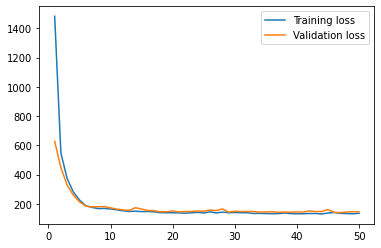

In [600]:
plot_curve(best_loss_record["train"], best_loss_record["valid"])

# Testing

In [525]:
model = NeuralNet(train_set.dataset.dim).to(device)
model_check_point = torch.load(model_save_path, map_location='cpu')
model.load_state_dict(model_check_point)

<All keys matched successfully>

In [602]:
best_model

NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

In [603]:
y_pred = test(best_model, test_set, device)

In [605]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['INDEX', 'PM2.5'])
        for i, p in enumerate(preds):
            writer.writerow([i+1, p])

In [607]:
submit_path = "./submission/submission_1031_5.csv"
save_pred(y_pred, submit_path)

Saving results to ./submission/submission_1031_5.csv


# EDA

In [21]:
for col in data_train.columns:
    plt.plot(data_train[col])
    plt.plot(data_train["PM2.5"])
    plt.legend([col, "PM2.5"])
    plt.title(col)
    plt.show()

NameError: name 'data_train' is not defined

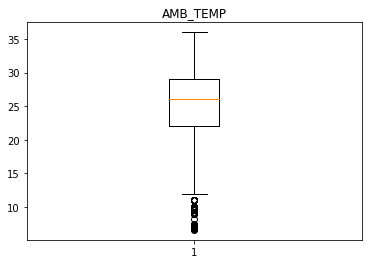

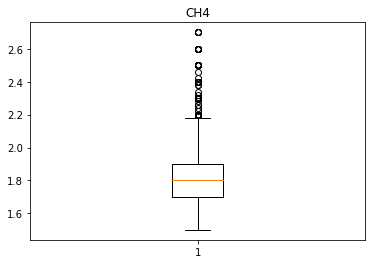

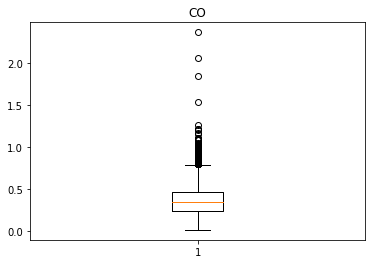

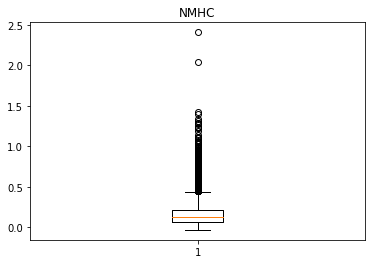

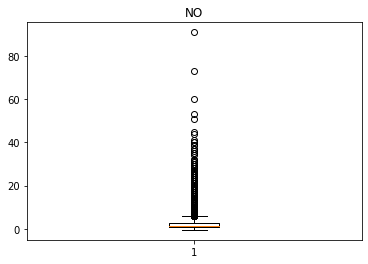

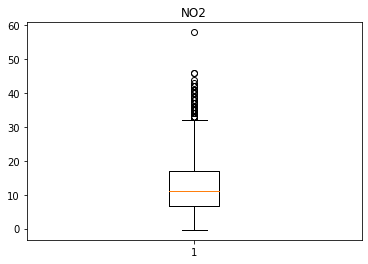

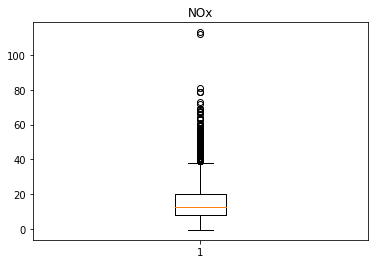

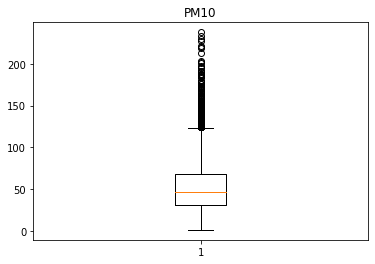

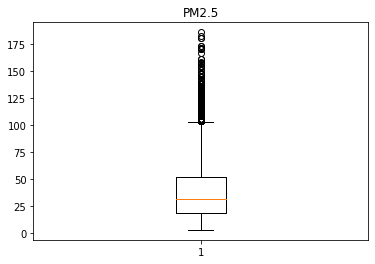

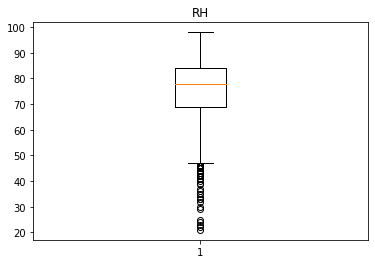

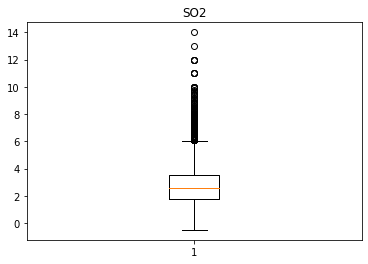

In [ ]:
for col in data_train.columns:
    plt.boxplot(data_train[col])
    plt.title(col)
    plt.show()

In [ ]:
data_test

,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,PM10,RH,SO2
0,19.0,2.1,0.40,0.19,1.8,20.0,22.0,57.0,91.0,2.1
1,18.0,2.2,0.46,0.18,3.9,19.0,23.0,65.0,92.0,2.6
2,18.0,2.3,0.46,0.17,5.3,19.0,25.0,61.0,92.0,2.6
3,18.0,2.3,0.46,0.19,14.0,22.0,37.0,58.0,93.0,2.5
4,18.0,2.2,0.37,0.16,4.1,17.0,21.0,41.0,93.0,2.0
...,...,...,...,...,...,...,...,...,...,...
8755,17.0,2.2,0.85,0.17,0.9,16.0,17.0,177.0,69.0,2.7
8756,17.0,2.2,0.82,0.17,0.9,18.0,18.0,143.0,70.0,2.3
8757,17.0,2.1,0.78,0.16,1.1,15.0,17.0,110.0,72.0,2.3
8758,16.0,2.1,0.73,0.14,1.2,17.0,18.0,96.0,73.0,2.4
